In [1]:
# Import PyTorch
import torch

# We use torchvision to get our dataset and useful image transformations
import torchvision
import torchvision.transforms as transforms

# Import PyTorch's optimization libary and nn
# nn is used as the basic building block for our Network graphs
import torch.optim as optim
import torch.nn as nn

# Are we using our GPU?
print("GPU available: {}".format(torch.cuda.is_available()))

from torch.autograd import Variable

GPU available: True


#### If GPU is available set device = ```'cuda'``` if not set device = ```'cpu'```

In [2]:
if torch.cuda.is_available():
  device = 'cuda' 
else:
  device = 'cpu' 

In [3]:
# Transform to a PyTorch tensors and the normalize our valeus between -1 and +1
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, ), (0.5, )) ])

In [4]:
# Load our Training Data and specify what transform to use when loading
trainset = torchvision.datasets.MNIST('mnist', 
                                      train = True, 
                                      download = True,
                                      transform = transform)

# Load our Test Data and specify what transform to use when loading
testset = torchvision.datasets.MNIST('mnist', 
                                     train = False,
                                     download = True,
                                     transform = transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw




Let's inspect our training and test dataset dimensions.

In [5]:
print(trainset.data.shape)
print(testset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


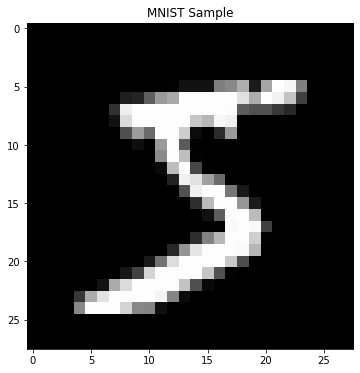

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Define our imshow function 
def imgshow(title="", image = None, size = 6):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

# Convert image to a numpy array
image = trainset.data[0].numpy()
imgshow("MNIST Sample", image)

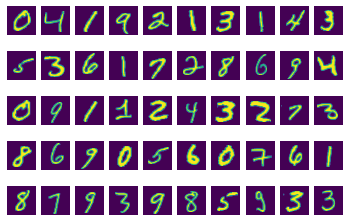

In [6]:
import matplotlib.pyplot as plt

figure = plt.figure()
num_of_images = 50 

for index in range(1, num_of_images + 1):
    plt.subplot(5, 10, index)
    plt.axis('off')
    plt.imshow(trainset.data[index])

In [7]:
# Prepare train and test loader
trainloader = torch.utils.data.DataLoader(trainset,
                                           batch_size = 128,
                                           shuffle = True,
                                           num_workers = 0)

testloader = torch.utils.data.DataLoader(testset,
                                          batch_size = 128,
                                          shuffle = False,
                                          num_workers = 0)

In [8]:
dataiter = iter(trainloader)

images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [10]:
# We import our optimizer function
import torch.optim as optim

# We use Cross Entropy Loss as our loss function
criterion = nn.CrossEntropyLoss()

# For our gradient descent algorthim or Optimizer
# We use Stochastic Gradient Descent (SGD) with a learning rate of 0.001
# We set the momentum to be 0.9
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters())

In [11]:
# We loop over the traing dataset multiple times (each time is called an epoch)
epochs = 10

# Create some empty arrays to store logs 
epoch_log = []
loss_log = []
accuracy_log = []

# Iterate for a specified number of epochs
for epoch in range(epochs):  
    print(f'Starting Epoch: {epoch+1}...')

    # We keep adding or accumulating our loss after each mini-batch in running_loss
    running_loss = 0.0

    # We iterate through our trainloader iterator
    # Each cycle is a minibatch
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Move our data to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        #inputs = Variable(inputs.view(1,3,128,32,32))

        # Clear the gradients before training by setting to zero
        # Required for a fresh start
        optimizer.zero_grad()

        # Forward -> backprop + optimize
        outputs = net(inputs) # Forward Propagation 
        loss = criterion(outputs, labels) # Get Loss (quantify the difference between the results and predictions)
        loss.backward() # Back propagate to obtain the new gradients for all nodes
        optimizer.step() # Update the gradients/weights

        # Print Training statistics - Epoch/Iterations/Loss/Accuracy
        running_loss += loss.item()
        if i % 50 == 49:    # show our loss every 50 mini-batches
            correct = 0 # Initialize our variable to hold the count for the correct predictions
            total = 0 # Initialize our variable to hold the count of the number of labels iterated

            # We don't need gradients for validation, so wrap in 
            # no_grad to save memory
            with torch.no_grad():
                # Iterate through the testloader iterator
                for data in testloader:
                    images, labels = data
                    # Move our data to GPU
                    images = images.to(device)
                    labels = labels.to(device)
                    
                    # Foward propagate our test data batch through our model
                    outputs = net(images)

                     # Get predictions from the maximum value of the predicted output tensor
                     # we set dim = 1 as it specifies the number of dimensions to reduce
                    _, predicted = torch.max(outputs.data, dim = 1)
                    # Keep adding the label size or length to the total variable
                    total += labels.size(0)
                    # Keep a running total of the number of predictions predicted correctly
                    correct += (predicted == labels).sum().item()

                accuracy = 100 * correct / total
                epoch_num = epoch + 1
                actual_loss = running_loss / 50
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%')
                running_loss = 0.0

    # Store training stats after each epoch
    epoch_log.append(epoch_num)
    loss_log.append(actual_loss)
    accuracy_log.append(accuracy)

print('Finished Training')

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 50, Loss: 2.258, Test Accuracy = 43.410%
Epoch: 1, Mini-Batches Completed: 100, Loss: 2.080, Test Accuracy = 70.200%
Epoch: 1, Mini-Batches Completed: 150, Loss: 1.583, Test Accuracy = 77.200%
Epoch: 1, Mini-Batches Completed: 200, Loss: 0.852, Test Accuracy = 83.530%
Epoch: 1, Mini-Batches Completed: 250, Loss: 0.551, Test Accuracy = 87.050%
Epoch: 1, Mini-Batches Completed: 300, Loss: 0.454, Test Accuracy = 88.570%
Epoch: 1, Mini-Batches Completed: 350, Loss: 0.409, Test Accuracy = 89.480%
Epoch: 1, Mini-Batches Completed: 400, Loss: 0.398, Test Accuracy = 88.840%
Epoch: 1, Mini-Batches Completed: 450, Loss: 0.373, Test Accuracy = 90.090%
Starting Epoch: 2...
Epoch: 2, Mini-Batches Completed: 50, Loss: 0.339, Test Accuracy = 90.280%
Epoch: 2, Mini-Batches Completed: 100, Loss: 0.322, Test Accuracy = 91.060%
Epoch: 2, Mini-Batches Completed: 150, Loss: 0.340, Test Accuracy = 91.520%
Epoch: 2, Mini-Batches Completed: 200, Loss: 0.3

## **10. Plotting our Training Logs**


```
# Create some empty arrays to store logs 
epoch_log = []
loss_log = []
accuracy_log = []
```



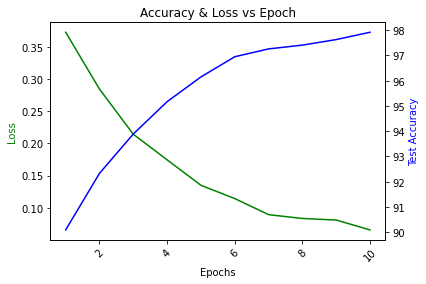

In [12]:
# To create a plot with secondary y-axis we need to create a subplot
fig, ax1 = plt.subplots()

# Set title and x-axis label rotation
plt.title("Accuracy & Loss vs Epoch")
plt.xticks(rotation=45)

# We use twinx to create a plot a secondary y axis
ax2 = ax1.twinx()

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, loss_log, 'g-')
ax2.plot(epoch_log, accuracy_log, 'b-')

# Set labels
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

In [13]:
nb_classes = 10

confusion_matrix = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[9.7100e+02, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.0000e+00, 1.0000e+00, 4.0000e+00, 1.0000e+00],
        [0.0000e+00, 1.1270e+03, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00],
        [5.0000e+00, 3.0000e+00, 9.9800e+02, 4.0000e+00, 2.0000e+00, 0.0000e+00,
         2.0000e+00, 6.0000e+00, 1.2000e+01, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.0000e+00, 9.8000e+02, 0.0000e+00, 9.0000e+00,
         0.0000e+00, 6.0000e+00, 1.2000e+01, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.6400e+02, 0.0000e+00,
         6.0000e+00, 3.0000e+00, 2.0000e+00, 7.0000e+00],
        [4.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 8.7400e+02,
         5.0000e+00, 1.0000e+00, 4.0000e+00, 1.0000e+00],
        [6.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00,
         9.3900e+02, 0.0000e+00, 6.0000e+00, 0.0000e+00],
        [2.0000e+00, 4.0000

In [14]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([0.9908, 0.9930, 0.9671, 0.9703, 0.9817, 0.9798, 0.9802, 0.9757, 0.9856,
        0.9604])


In [15]:
from sklearn.metrics import confusion_matrix

nb_classes = 10

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[[ 971    0    1    0    0    0    2    1    4    1]
 [   0 1127    3    0    0    0    2    0    3    0]
 [   5    3  998    4    2    0    2    6   12    0]
 [   0    0    2  980    0    9    0    6   12    1]
 [   0    0    0    0  964    0    6    3    2    7]
 [   4    1    0    2    0  874    5    1    4    1]
 [   6    3    0    0    2    2  939    0    6    0]
 [   2    4    9    2    0    0    0 1003    4    4]
 [   6    0    1    0    2    0    1    3  960    1]
 [   4    6    0    3    4    1    1   11   10  969]]
[99.08163265 99.29515419 96.70542636 97.02970297 98.16700611 97.98206278
 98.01670146 97.56809339 98.56262834 96.03567889]
